# DA for DMD kol_model.py

In [1]:
import random
from time import perf_counter

import torch
from torch import nn
import torch.nn.functional as F
import numpy
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)


def set_device():
    """
    Use CPU if cuda device is not available
    setup tf32 for faster GPU computation
    """
    if torch.cuda.device_count() == 0:
        return "cpu"
    torch.set_float32_matmul_precision("high")
    return "cuda"


set_seed(42)
g = torch.Generator()
g.manual_seed(42)
device = set_device()
device

/scratch_dgxl/wy524/miniconda3/envs/irp-env/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


'cpu'

In [2]:
from kol_model import KOL_C_FORWARD

forward_model = KOL_C_FORWARD()
forward_model.load_state_dict(torch.load('kol_model_weights/forward_model.pt', weights_only=True, map_location=device))
forward_model.C_forward = torch.load('kol_model_weights/C_forward.pt', weights_only=True, map_location=device)
forward_model.eval()

print(forward_model)

KOL_C_FORWARD(
  (K_S): KOL_K_S(
    (Conv2D_size7_1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (Conv2D_size5_1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (Conv2D_size3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Conv2D_size3_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Conv2D_size3_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (pooling): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (relu): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

In [3]:
from Dataset import KolDynamicsDataset

foward_step = 12

val_idx = 3

kol_train_dataset = KolDynamicsDataset(data_path="../../../data/kolmogorov/kolmogorov_train_data.npy",
                seq_length = foward_step,
                mean=None,
                std=None)
    
kol_val_dataset = KolDynamicsDataset(data_path="../../../data/kolmogorov/kolmogorov_val_data.npy",
            seq_length = foward_step,
            mean=kol_train_dataset.mean,
            std=kol_train_dataset.std)

denorm = kol_val_dataset.denormalizer()

Loaded Cylinder data with shape: (96, 320, 1, 64, 64)
dataset total samples: 29568
Loaded Cylinder data with shape: (24, 320, 1, 64, 64)
dataset total samples: 7392


In [4]:
groundtruth = kol_val_dataset.data[val_idx, ...]
groundtruth = torch.from_numpy(groundtruth)

groundtruth.shape

torch.Size([320, 1, 64, 64])

In [5]:
def visualize_image(image_2d, title='Image', cmap='viridis'):
    if isinstance(image_2d, torch.Tensor):
        image_2d = image_2d.detach().cpu().numpy()

    plt.figure(figsize=(2, 2))
    plt.imshow(image_2d, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
import os
import sys
import numpy as np

class SparseObservationHandler:
    
    def __init__(self, observation_ratio: float = 0.1, seed: int = 42):
        self.observation_ratio = observation_ratio
        self.seed = seed
        self.observation_mask = None
        self.observation_indices = None
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
    
    def generate_observation_mask(self, image_shape):
        if len(image_shape) == 4:  # (B, C, H, W)
            _, C, H, W = image_shape
        elif len(image_shape) == 3:  # (C, H, W)
            C, H, W = image_shape
        else:
            raise ValueError(f"Unsupported image shape: {image_shape}")
        
        total_pixels = C * H * W
        num_observations = int(total_pixels * self.observation_ratio)
        
        observation_indices = torch.randperm(total_pixels)[:num_observations]
        
        mask = torch.zeros(total_pixels, dtype=torch.bool)
        mask[observation_indices] = True
        
        self.observation_mask = mask
        self.observation_indices = observation_indices
        
        return mask, observation_indices
    
    def apply_sparse_observation(self, full_image, mask=None):
        if mask is None:
            mask = self.observation_mask
        
        flat_image = full_image.flatten()
        observed_values = flat_image[mask]
        
        return observed_values

### DA

In [7]:
import torchda

In [8]:
# del cyl_train_dataset
# del cyl_val_dataset

In [9]:
observation_ratio = 0.4
obs_handler = SparseObservationHandler(observation_ratio=observation_ratio, seed=42)

In [10]:
start_da_end_idxs = (100, 110, 130)

time_obs = [
    start_da_end_idxs[1], # 750
    start_da_end_idxs[1] + 10, # 760
]
gaps = [10] * (len(time_obs) - 1)

full_y_data = [
    kol_val_dataset.normalize(groundtruth[i, ...])
    for i in range(groundtruth.shape[0])
    if i in time_obs
]

full_y_data = torch.cat(full_y_data).to(device) # +1

In [11]:
print(full_y_data.shape)

torch.Size([2, 1, 64, 64])


In [12]:
sample_image_shape = full_y_data[0].shape  # (C, H, W)
mask, indices = obs_handler.generate_observation_mask(sample_image_shape)
mask = mask.to(device)

sparse_y_data = []
for full_img in full_y_data:
    sparse_obs = obs_handler.apply_sparse_observation(full_img, mask)
    sparse_y_data.append(sparse_obs)
sparse_y_data = torch.stack(sparse_y_data)

print(f"Original observation shape: {full_y_data.shape}")
print(f"Sparse observation shape: {sparse_y_data.shape}")
print(f"Observation ratio: {sparse_y_data.shape[1] / full_y_data[0].numel():.3f}")

Original observation shape: torch.Size([2, 1, 64, 64])
Sparse observation shape: torch.Size([2, 1638])
Observation ratio: 0.400


In [13]:
def H_sparse(x):
    x_reconstructed = forward_model.K_S_preimage(x)
    sparse_obs = obs_handler.apply_sparse_observation(x_reconstructed.squeeze(), mask)
    return sparse_obs.unsqueeze(0)

In [14]:
latent_dim = forward_model.C_forward.shape[0]
B = torch.eye(latent_dim, device=device)

obs_dim = sparse_y_data.shape[1]
R = 1e-10 * torch.eye(obs_dim, device=device)

print(f"Background covariance B shape: {B.shape}")
print(f"Observation covariance R shape: {R.shape}")

Background covariance B shape: torch.Size([512, 512])
Observation covariance R shape: torch.Size([1638, 1638])


In [15]:
def dmd_warpper(z_t, time_fw=None, *args):
    if time_fw == None:
        if z_t.ndim == 1:
            z_t = z_t.unsqueeze(0)

        y0 = z_t
        y = forward_model.latent_forward(y0)
        
    else:
        if z_t.ndim == 1:
            z_t = z_t.unsqueeze(0)

        y0 = z_t
        y = torch.empty((z_t.shape[1], time_fw.shape[0]), device=z_t.device)
        y[:, 0] = y0
        for i in range(1, int(time_fw.shape[0])):
            y0 = forward_model.latent_forward(y0)
            y[:, i] = y0
        
        y = y.T.unsqueeze_(1)
    return y

In [16]:
case_to_run = (
    torchda.CaseBuilder()
    .set_observation_time_steps(time_obs)
    .set_gaps(gaps)
    .set_forward_model(dmd_warpper)
    .set_observation_model(H_sparse)
    .set_background_covariance_matrix(B)
    .set_observation_covariance_matrix(R)
    .set_observations(sparse_y_data)
    .set_optimizer_cls(torch.optim.Adam)
    .set_optimizer_args({"lr": 0.05})
    .set_max_iterations(10000)
    .set_algorithm(torchda.Algorithms.Var4D)
    .set_device(torchda.Device.CPU)
    .set_output_sequence_length(1)
)

In [17]:
outs_4d_da = []

start_time = perf_counter()
for i in range(groundtruth.shape[0]):
    if i < start_da_end_idxs[0]:
        continue
    elif i == start_da_end_idxs[-1] + 1:
        break
    print(f"Processing step {i}")
    
    if i == start_da_end_idxs[0]:
        out = forward_model.K_S(kol_val_dataset.normalize(groundtruth[i]))
        continue
        
    if i == start_da_end_idxs[1]:
        case_to_run.set_background_state(out.ravel())
        result = case_to_run.execute()
        out = result["assimilated_state"]
        
        intermediate_results = result["intermediate_results"]
        final_cost = intermediate_results["J"][-1]
        print(f"Final cost function: {final_cost}")
        print(f"Number of iterations: {len(intermediate_results['J'])}")
        
    outs_4d_da.append(out)
    out = dmd_warpper(out)
    print("=" * 50)

print(f"Sparse observation 4D-Var time: {perf_counter() - start_time}s")

Processing step 100
Processing step 101
Processing step 102
Processing step 103
Processing step 104
Processing step 105
Processing step 106
Processing step 107
Processing step 108
Processing step 109
Processing step 110


[W708 22:49:13.299881523 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


Timestamp: 2025-07-08 22:49:18.118881, Iterations: 0, Jb: 0.0, Jo: 37942617702400.0, J: 37942617702400.0, Norm of J gradient: 8453309440.0
Timestamp: 2025-07-08 22:49:18.157060, Iterations: 1, Jb: 1.2800055742263794, Jo: 37926800982016.0, J: 37926800982016.0, Norm of J gradient: 125272907776.0
Timestamp: 2025-07-08 22:49:18.192543, Iterations: 2, Jb: 2.5649569034576416, Jo: 37833465135104.0, J: 37833465135104.0, Norm of J gradient: 229371199488.0
Timestamp: 2025-07-08 22:49:18.228019, Iterations: 3, Jb: 4.66162109375, Jo: 37691248869376.0, J: 37691248869376.0, Norm of J gradient: 287536316416.0
Timestamp: 2025-07-08 22:49:18.262287, Iterations: 4, Jb: 7.738587379455566, Jo: 37496847073280.0, J: 37496847073280.0, Norm of J gradient: 351898828800.0
Timestamp: 2025-07-08 22:49:18.294664, Iterations: 5, Jb: 11.922039031982422, Jo: 37294945861632.0, J: 37294945861632.0, Norm of J gradient: 314017841152.0
Timestamp: 2025-07-08 22:49:18.327209, Iterations: 6, Jb: 17.080320358276367, Jo: 37162

In [18]:
outs_no_4d_da = []
start_time = perf_counter()
with torch.no_grad():
    for i in range(groundtruth.shape[0]):
        if i < start_da_end_idxs[0]:
            continue
        elif i == start_da_end_idxs[-1] + 1:
            break
        print(i)
        if i == start_da_end_idxs[0]:
            out = forward_model.K_S(kol_val_dataset.normalize(groundtruth[i])) # 750
            continue
        outs_no_4d_da.append(out)
        out = dmd_warpper(out)
        print("===============================")
print(f"time elapse for pure dmd: {perf_counter() - start_time}s")

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
time elapse for pure dmd: 0.008804101031273603s


In [19]:
real_img = groundtruth

len(outs_4d_da), len(outs_no_4d_da), real_img.shape

(30, 30, torch.Size([320, 1, 64, 64]))

In [20]:
# diffs = []
diffs_da_real_mse = []
diffs_noda_real_mse = []
diffs_da_real_rrmse = []
diffs_noda_real_rrmse = []
diffs_da_real_ssim = []
diffs_noda_real_ssim = []

with torch.no_grad():
    for i, (no_da, da) in enumerate(zip(outs_no_4d_da, outs_4d_da), start=start_da_end_idxs[0]):
        
        da_img = forward_model.K_S_preimage(da).view(1, 64, 64)
        noda_img = forward_model.K_S_preimage(no_da).view(1, 64, 64)

        de_da_img = denorm(da_img)
        de_noda_img = denorm(noda_img)
        
        da_minus_real_img_square = (de_da_img[0] - real_img[i]) ** 2
        noda_minus_real_img_square = (de_noda_img[0] - real_img[i]) ** 2

        diffs_da_real_mse.append(da_minus_real_img_square.mean())
        diffs_noda_real_mse.append(noda_minus_real_img_square.mean())

        diffs_da_real_rrmse.append((da_minus_real_img_square.sum()/((real_img[i]**2).sum())).sqrt())
        diffs_noda_real_rrmse.append((noda_minus_real_img_square.sum()/((real_img[i]**2).sum())).sqrt())

        diffs_da_real_ssim.append(ssim(real_img[i].numpy(), de_da_img[0].numpy(), data_range=1, channel_axis=0))
        diffs_noda_real_ssim.append(ssim(real_img[i].numpy(), de_noda_img[0].numpy(), data_range=1, channel_axis=0))

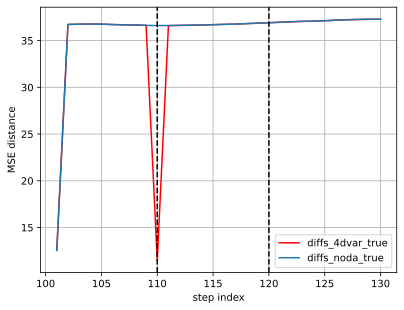

diffs_noda_real_mse[da_idxs[0]]=tensor(36.6075), diffs_noda_real_mse[da_idxs[1]]=tensor(36.9153)
diffs_da_real_mse[da_idxs[0]]=tensor(11.4731), diffs_da_real_mse[da_idxs[1]]=tensor(36.9153)
diffs_noda_real_rrmse[da_idxs[0]]=tensor(1.0378), diffs_noda_real_rrmse[da_idxs[1]]=tensor(1.0427)
diffs_da_real_rrmse[da_idxs[0]]=tensor(0.5810), diffs_da_real_rrmse[da_idxs[1]]=tensor(1.0427)
diffs_noda_real_ssim[da_idxs[0]]=np.float32(-0.00047980918), diffs_noda_real_ssim[da_idxs[1]]=np.float32(-0.0018108977)
diffs_da_real_ssim[da_idxs[0]]=np.float32(0.4861819), diffs_da_real_ssim[da_idxs[1]]=np.float32(-0.0018108977)


In [21]:
step_idxs = list(range(start_da_end_idxs[0] + 1, start_da_end_idxs[-1] + 1))

plt.plot(step_idxs, diffs_da_real_mse, color="r", label="diffs_4dvar_true")
plt.plot(step_idxs, diffs_noda_real_mse, color="#1f77b4", label="diffs_noda_true")
for x in time_obs:
    plt.axvline(x=x, color="k", linestyle="--")
plt.xlabel("step index")
plt.ylabel("MSE distance")
plt.grid(True)
plt.legend()

plt.show()

da_idxs = [9, 19]
print(f"{diffs_noda_real_mse[da_idxs[0]]=}, {diffs_noda_real_mse[da_idxs[1]]=}")
print(f"{diffs_da_real_mse[da_idxs[0]]=}, {diffs_da_real_mse[da_idxs[1]]=}")
print(f"{diffs_noda_real_rrmse[da_idxs[0]]=}, {diffs_noda_real_rrmse[da_idxs[1]]=}")
print(f"{diffs_da_real_rrmse[da_idxs[0]]=}, {diffs_da_real_rrmse[da_idxs[1]]=}")
print(f"{diffs_noda_real_ssim[da_idxs[0]]=}, {diffs_noda_real_ssim[da_idxs[1]]=}")
print(f"{diffs_da_real_ssim[da_idxs[0]]=}, {diffs_da_real_ssim[da_idxs[1]]=}")

torch.Size([64, 64])
19171.592
9832.007
torch.Size([64, 64])
19062.809
19062.809


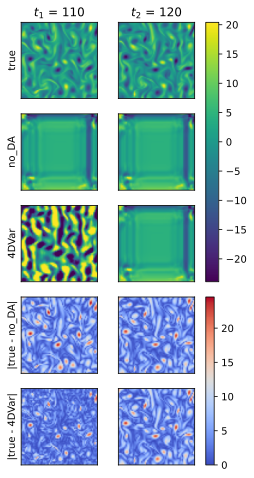

In [22]:
fig, ax = plt.subplots(5, len(da_idxs), figsize=(2 * len(da_idxs), 8), sharex=True)
for x in ax.flat:
    x.set_xticks([])
    x.set_yticks([])
    x.set_xticklabels([])
    x.set_yticklabels([])

setup_cmap = True
with torch.no_grad():
    for i, da_idx in enumerate(da_idxs):
        img_tensor = real_img[time_obs[i], 0, ...]
        print(img_tensor.shape)
        im1 = ax[0, i].imshow(torch.reshape(img_tensor, (64, 64)), cmap="viridis")
        if setup_cmap:
            # Create a ScalarMappable object with the colormap from images
            sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)
        no_da = forward_model.K_S_preimage(outs_no_4d_da[da_idx]).cpu()
        da = forward_model.K_S_preimage(outs_4d_da[da_idx]).cpu()

        de_no_da = denorm(no_da)
        de_da = denorm(da)

        image_noda = de_no_da[0, 0, ...]
        image_da = de_da[0, 0, ...]

        print(np.sum(np.abs(img_tensor.numpy() - image_noda.numpy())))
        print(np.sum(np.abs(img_tensor.numpy() - image_da.numpy())))

        ax[1, i].imshow(torch.reshape(image_noda, (64, 64)), cmap="viridis")
        ax[2, i].imshow(torch.reshape(image_da, (64, 64)), cmap="viridis")
        res = (img_tensor.reshape((64, 64)) - image_noda.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        im2 = ax[3, i].imshow(res, cmap="coolwarm")
        if setup_cmap:
            sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
        res = (img_tensor.reshape((64, 64)) - image_da.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        ax[4, i].imshow(res, cmap="coolwarm")
        setup_cmap = False

for i, title in enumerate([f"$t_1$ = {time_obs[0]}", f"$t_2$ = {time_obs[1]}"]):
    ax[0, i].set_title(title)
# ax[0].set_title("$t$")
for i, ylabel in enumerate(["true", "no_DA", "4DVar", "|true - no_DA|", "|true - 4DVar|"]):
    ax[i, 0].set_ylabel(ylabel)

# # Create a ScalarMappable object with the colormap from images
# sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)

# Remove the set_array to avoid warning
sm1.set_array([])

# Add a colorbar to the figure that uses the ScalarMappable
# fig.colorbar(sm1, ax=ax, orientation="vertical")

fig.colorbar(sm1, ax=ax[:-2, :], orientation="vertical")
sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[-2:, :], orientation="vertical")

plt.show()